In [9]:
import freud
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.library import PolyEthylene, OPLS_AA
from flowermd.library.forcefields import FF_from_file
from flowermd import Pack
from flowermd.base import Molecule, Lattice, Simulation
from cmeutils.visualize import FresnelGSD
import gsd
import matplotlib.pyplot as plt
import numpy as np
import gsd.hoomd

cpu = hoomd.device.CPU() # So I don't get a CUDA error on local machine
nematic = freud.order.Nematic()

In [4]:
molecule = PolyEthylene(num_mols=30, lengths=20)

box = Lattice(molecules=molecule, x = 5, y = 5, n = 4)
box.apply_forcefield(r_cut=2.5, force_field=OPLS_AA(), auto_scale=True,remove_charges=True, remove_hydrogens=True)

No charged group detected, skipping electrostatics.


In [6]:
box.hoomd_snapshot
hoomd_forces = box.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()
dict(lj_force.params)

{'CT-CT-CT': _HOOMDDict{'t0': 1.966986067, 'k': 1768.182542441625}}

In [11]:
sim = Simulation.from_system(system=box, gsd_write_freq=100, log_write_freq=100, device=cpu, gsd_file_name='pe-melt.gsd')

Initializing simulation state from a gsd.hoomd.Frame.


In [13]:
box.system.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
sim.run_NVT(n_steps=2e5, kT=5.0, tau_kt=1.0)
sim.flush_writers()

Step 100 of 200000; TPS: 315.74; ETA: 10.6 minutes
Step 200 of 200000; TPS: 570.8; ETA: 5.8 minutes
Step 300 of 200000; TPS: 783.44; ETA: 4.2 minutes
Step 400 of 200000; TPS: 965.38; ETA: 3.4 minutes
Step 500 of 200000; TPS: 1124.15; ETA: 3.0 minutes
Step 600 of 200000; TPS: 1256.19; ETA: 2.6 minutes
Step 700 of 200000; TPS: 1373.01; ETA: 2.4 minutes
Step 800 of 200000; TPS: 1480.17; ETA: 2.2 minutes
Step 900 of 200000; TPS: 1572.87; ETA: 2.1 minutes
Step 1000 of 200000; TPS: 1654.56; ETA: 2.0 minutes
Step 1100 of 200000; TPS: 1726.23; ETA: 1.9 minutes
Step 1200 of 200000; TPS: 1802.5; ETA: 1.8 minutes
Step 1300 of 200000; TPS: 1870.28; ETA: 1.8 minutes
Step 1400 of 200000; TPS: 1936.31; ETA: 1.7 minutes
Step 1500 of 200000; TPS: 1994.48; ETA: 1.7 minutes
Step 1600 of 200000; TPS: 2053.03; ETA: 1.6 minutes
Step 1700 of 200000; TPS: 2105.68; ETA: 1.6 minutes
Step 1800 of 200000; TPS: 2150.42; ETA: 1.5 minutes
Step 1900 of 200000; TPS: 2194.47; ETA: 1.5 minutes
Step 2000 of 200000; TPS: 

In [16]:
traj = gsd.hoomd.open('pe-melt.gsd')

In [40]:
def nop(frame):
    positions = frame.particles.position
    molecule_ids = frame.bonds.group
    temp = positions[0]
    vectors = []
    for group in frame.bonds.group:
        vectors.append(positions[group[1]] - positions[group[0]])
    vectors = np.array(vectors)
    return vectors

In [41]:
nematic = freud.order.Nematic(np.array([1,0,0]))
import time
start = time.process_time()
orders = []
frames = []
count = 0
for frame in traj:
    count += 1
    frames.append(count)
    nematic.compute(nop(frame))
    orders.append(nematic.order)
    print("Nematic Order Parameter:", nematic.order)
print("Time taken:", time.process_time() - start, "s")

Nematic Order Parameter: 0.5048778057098389
Nematic Order Parameter: 0.48279476165771484
Nematic Order Parameter: 0.4770728647708893
Nematic Order Parameter: 0.5075984597206116
Nematic Order Parameter: 0.49129003286361694
Nematic Order Parameter: 0.4682197570800781
Nematic Order Parameter: 0.4924229383468628
Nematic Order Parameter: 0.4841698110103607
Nematic Order Parameter: 0.46302422881126404
Nematic Order Parameter: 0.4838508367538452
Nematic Order Parameter: 0.4805877208709717
Nematic Order Parameter: 0.4594399333000183
Nematic Order Parameter: 0.47347021102905273
Nematic Order Parameter: 0.47248825430870056
Nematic Order Parameter: 0.44932642579078674
Nematic Order Parameter: 0.4564611613750458
Nematic Order Parameter: 0.4588756263256073
Nematic Order Parameter: 0.43942415714263916
Nematic Order Parameter: 0.44301989674568176
Nematic Order Parameter: 0.44630423188209534
Nematic Order Parameter: 0.4293215274810791
Nematic Order Parameter: 0.42974790930747986
Nematic Order Paramete

Text(0, 0.5, 'Nematic order parameter')

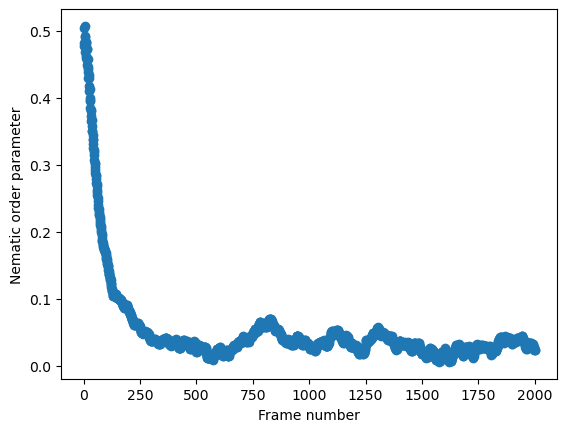

In [42]:
plt.scatter(frames, orders)
plt.xlabel("Frame number")
plt.ylabel("Nematic order parameter")